<div style="text-align: center;">
    <h1 style="color: green;">Anexo 16</h1>
    <h3>Proyecto 16: Modelado de Temas con LDA</h3>
    <hr/>
    <p style="text-align: right;">Mg. Luis Felipe Bustamante Narváez</p>
</div>

En este ejercicio, desarrollaremos un clustering de temas de acuerdo con un dataset que contiene transcripciones de entrevistas, bastante extensas y en español. Se quiere desarrollar un clasificador que permita identificar los temas que se trabajan en cada transcripción de manera que se pueda predecir de qué habla cada una de ellas, y qué afinidad tiene con otras.

Recordemos que, **Clustering** (o agrupamiento) es una técnica de aprendizaje no supervisado cuyo objetivo es agrupar objetos similares entre sí y diferentes de los de otros grupos, sin tener etiquetas previas.

## Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

## Manejo de StopWords

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luis_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words_original = set(stopwords.words('spanish'))

In [5]:
# Convertimos el conjunto en lista
_stop_words_original = list(stop_words_original)
_stop_words_original[:10]

['sobre',
 'habíais',
 'estarían',
 'unos',
 'por',
 'estás',
 'tienen',
 'estabais',
 'eran',
 'habríamos']

#### Explicación

En una entrevista, de acuerdo con los datos que vamos a analizar, se presentan palabras adicionales a las que un texto pueda llegar a tener, palabras relacionadas con preguntas, exclamaciones, entre otras, que se repiten constantemente y que no aportan al procesamiento de datos.

Por este motivo, adicionaremos algunas palabras observadas en las entrevistas para mejorar el proceso.

In [6]:
path_json = 'data/stop_words_news.json'
stop_words_news = pd.read_json(path_json, encoding='utf-8')

In [7]:
stop_words_news[:10]

,words
0,así
1,si
2,hacer
3,cosas
4,creo
5,cómo
6,solo
7,aquí
8,risas
9,ser


In [8]:
stop_words_news = set(stop_words_news['words'])

In [10]:
stop_words_add = stop_words_original.union(stop_words_news)

In [11]:
_stop_words_add = list(stop_words_add)
_stop_words_add[:10]

['sobre',
 'habíais',
 'estarían',
 'ser',
 'sentido',
 'hombre',
 'unos',
 'fuésemos',
 'habidas',
 'por']

***Nota:*** *Primero realizaremos el proceso con las stopwords de la librería y luego con las que hemos añadido, de tal manera poder observar si hay diferencias en el clustering.*

Resultado del LDA con las palabras originales de la librería
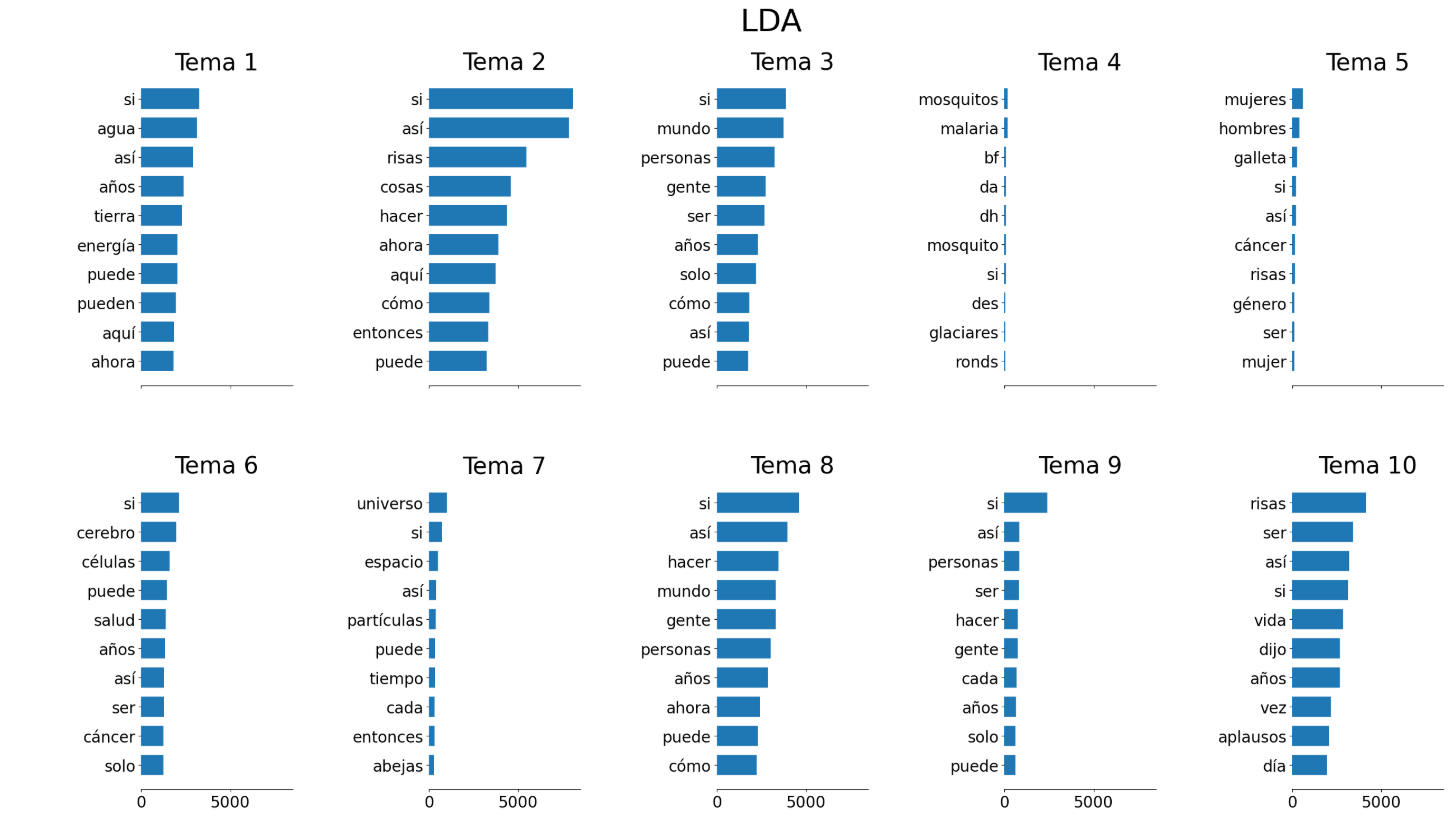

Posteriormente, se ejecutó con palabras añadidas; este es el producto real esperado del LDA, mostrado en las siguientes celdas de código.


## Cargamos los Datos

In [12]:
path = 'data/ted_talks_es.csv'
df = pd.read_csv(path)

In [13]:
df.iloc[:4,16:]

,url,description,transcript
0,https://www.ted.com/talks/al_gore_averting_the...,Con el mismo humor y humanidad que irradió en ...,Muchas gracias Chris. Y es en verdad un gran h...
1,https://www.ted.com/talks/david_pogue_simplici...,"El columnista del New York Times, David Pogue,...","Hola contestadora automática, mi vieja amiga. ..."
2,https://www.ted.com/talks/majora_carter_greeni...,"En una charla altamente emotiva, la activista ...","Si están presentes aquí hoy, y estoy muy conte..."
3,https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson plantea de manera entretenida...,"Buenos días. ¿Cómo están? Ha sido increíble, ¿..."


In [14]:
df['transcript'][0][:500]

'Muchas gracias Chris. Y es en verdad un gran honor tener la oportunidad de venir a este escenario por segunda vez. Estoy extremadamente agradecido. He quedado conmovido por esta conferencia, y deseo agradecer a todos ustedes sus amables comentarios acerca de lo que tenía que decir la otra noche. Y digo eso sinceramente, en parte porque — (Sollozos fingidos) — ¡lo necesito! (Risas) ¡Pónganse en mi posición! Volé en el avión vicepresidencial por ocho años. ¡Ahora tengo que quitarme mis zapatos o b'

## Procesamiento de los Datos

### Vectorización

In [15]:
# Cada vector es una conferencia y cada conferencia tiene vectores de cada palabra
vectorizer = CountVectorizer(stop_words=_stop_words_add)

In [16]:
# Aplicamos la vectorización a nuestro dataset
X = vectorizer.fit_transform(df['transcript'])
X

<3921x111271 sparse matrix of type '<class 'numpy.int64'>'
	with 1889073 stored elements in Compressed Sparse Row format>

### Modelo LDA

In [17]:
lda = LatentDirichletAllocation(
    n_components=10,  #default:10
    random_state=12354,  #estados aleatorios - semilla de la forma en que comienzan
)

In [18]:
lda.fit(X)

LatentDirichletAllocation(random_state=12354)

## Gráfico de Palabras TOP

In [21]:
def graficar_palabras_top(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_index, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Tema {topic_index + 1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize= 20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('LDA', fontsize= 40)
    plt.subplots_adjust(top= 0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

#### Explicación

La función <span style="color:fuchsia"><strong>graficar_palabras_top</strong></span> sirve para visualizar las palabras más importantes de cada tema generado por un modelo <span style="color:fuchsia"><strong>LDA</strong></span>, que es comúnmente usado en procesamiento de lenguaje natural para descubrir temas latentes en un conjunto de textos.

Primero, en la definición de la función, se reciben tres parámetros: el modelo <span style="color:fuchsia"><strong>LDA</strong></span> ya entrenado, una lista de nombres de las palabras (que suelen provenir de un <span style="color:fuchsia"><strong>CountVectorizer</strong></span> o <span style="color:fuchsia"><strong>TfidfVectorizer</strong></span>), y un número opcional que indica cuántas palabras principales por tema se quieren graficar (por defecto <span style="color:fuchsia"><strong>10</strong></span>).

Luego, se crea una figura con <span style="color:fuchsia"><strong>10 subgráficas</strong></span> organizadas en 2 filas y 5 columnas, lo cual permite visualizar hasta 10 temas. Estas subgráficas se aplanan usando <span style="color:fuchsia"><strong>flatten()</strong></span> para que sea más fácil iterar sobre ellas.

Después, comienza un ciclo con <span style="color:fuchsia"><strong>enumerate</strong></span> que recorre cada tema del modelo. Cada tema se representa como un vector que contiene los pesos (importancia) de cada palabra. Se ordenan estos pesos con <span style="color:fuchsia"><strong>argsort()</strong></span> para seleccionar las palabras más relevantes del tema, tomando sus índices. Luego, se usan esos índices para obtener tanto los nombres de las palabras como sus respectivos pesos.

Con esa información, se crea un gráfico de barras horizontal usando <span style="color:fuchsia"><strong>barh()</strong></span> en la subgráfica correspondiente, donde las palabras están en el eje Y y sus pesos en el eje X. Se le da un título a cada gráfico con el número del tema usando <span style="color:fuchsia"><strong>set_title</strong></span>, se invierte el eje Y con <span style="color:fuchsia"><strong>invert_yaxis()</strong></span> para que la palabra más importante esté arriba, y se ajustan los tamaños de fuente con <span style="color:fuchsia"><strong>tick_params</strong></span> para que sea más legible. También se eliminan algunos bordes del gráfico con <span style="color:fuchsia"><strong>set_visible(False)</strong></span> para que se vea más limpio.

Finalmente, se añade un título general a toda la figura con <span style="color:fuchsia"><strong>suptitle()</strong></span>, se ajusta el espacio entre los gráficos con <span style="color:fuchsia"><strong>subplots_adjust()</strong></span>, y se muestra el resultado con <span style="color:fuchsia"><strong>plt.show()</strong></span>.

En resumen, esta función te ayuda a interpretar de manera visual qué palabras definen cada tema extraído por el modelo LDA, lo cual es clave para entender los patrones latentes en un conjunto de textos.

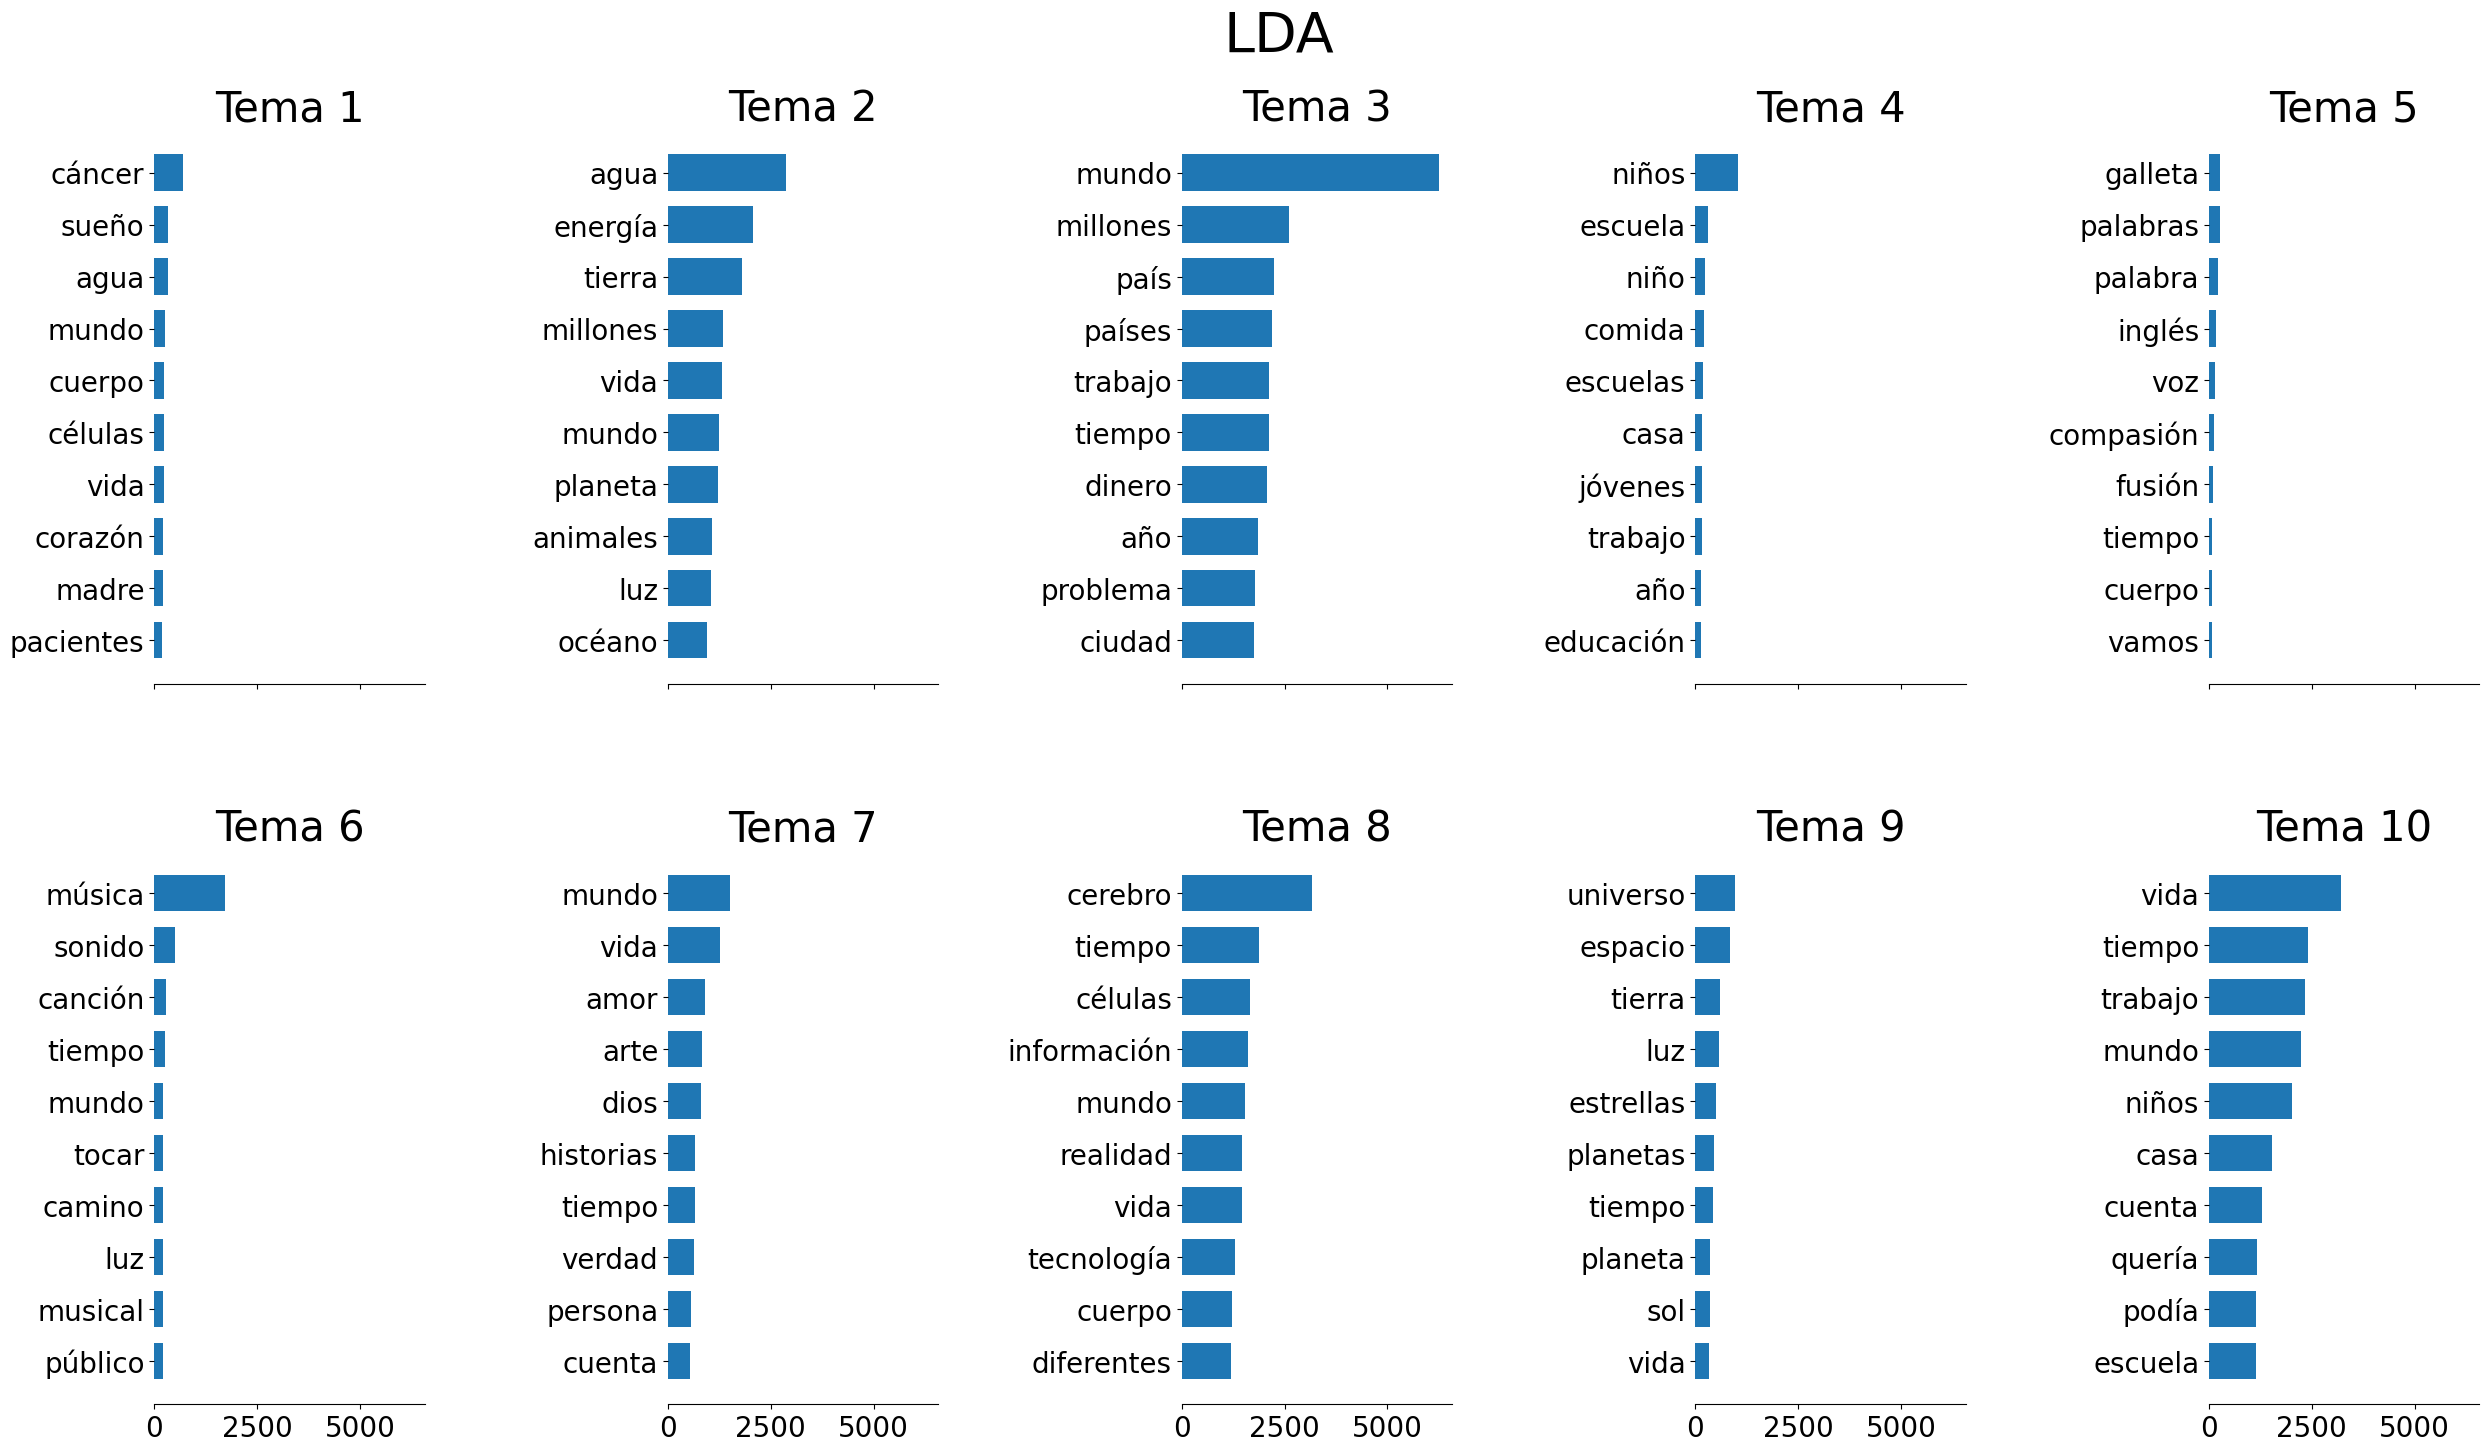

In [22]:
# Obtenemos las palabras
palabras = vectorizer.get_feature_names_out()
# llamamos la función para graficar
graficar_palabras_top(lda, palabras);

## Prueba del Modelo LDA

Seleccionamos un tema al azar de toda la base de datos, y el modelo debe indicarnos de qué tema está hablando.

### Matriz transformada

In [23]:
Z = lda.transform(X)

### Solución gráfica

Entrevista seleccionada al azar, número 2460


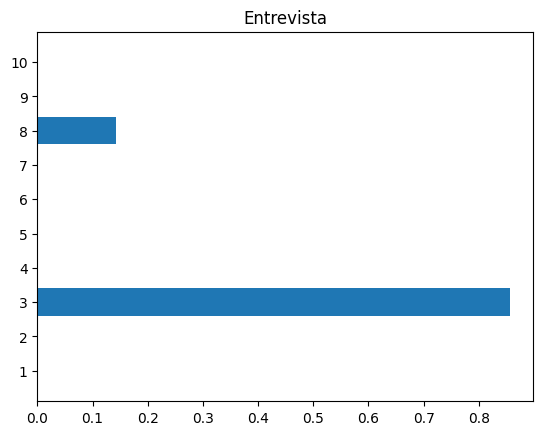

In [24]:
np.random.seed(1111)  # semilla fija
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('Entrevista');
print(f'Entrevista seleccionada al azar, número {i}')

### Tema de la entrevista seleccionada - Comparación

In [25]:
def wrap(x):
    entrevista = textwrap.fill(x,
                              replace_whitespace=False,
                              fix_sentence_endings=True)
    return entrevista

In [26]:
print(wrap(df.iloc[i]['transcript'][:500]))

Hoy voy a hablar de tecnología y de la sociedad.  El Departamento de
Transporte estimó que, el año pasado, hubo 35 000 muertos en
accidentes de auto, tan solo en EE.UU. A nivel mundial, mueren 1,2
millones de personas por año en accidentes de auto.  Si hubiera una
manera de eliminar el 90 % de esos accidentes, ¿apoyarían la causa?
Por supuesto que lo harían.  Esto es lo que promete la tecnología de
vehículos autónomos, al eliminar la principal causa de accidentes: el
error humano.  Imagínense en el


## Conclusiones

<div style="text-align: center;">
    <p>LDA, permite crear un clustering de temas y palabras asociadas a la información que trae el texto por defecto, generando un proceso estadístico capaz de filtrar la información para ofrecer mejores interpretaciones en el procesamiento de documentos.</p>
    <hr/>
    <p style="text-align: right;">Mg. Luis Felipe Bustamante Narváez</p>
</div>